In [1]:
import numpy
import ipywidgets
from matplotlib import pyplot

%matplotlib inline

In [2]:
pyplot.rc('font', family='serif',size=16)

In [3]:
def rho_red_light(x,rho_max):
    rho = numpy.full_like(x,rho_max)
    #rho = rho_max*numpy.ones_like(x)
    mask = numpy.where(x<3.0)
    rho[mask] /= 2
    #rho[mask]= rho_max/2
    return rho

In [4]:
#set parameters
nx = 81
L = 4.0
dx = L/(nx-1)
x= numpy.linspace(0.0,L,num = nx)

rho_max = 10.0
u_max = 1.0

rho0 = rho_red_light(x, rho_max)

In [5]:
def plot(n, x, rho_hist):
    pyplot.figure()
    pyplot.grid()
    pyplot.title('Time Step:{}'.format(n))
    pyplot.xlabel('Road[km]')
    pyplot.ylabel('traffic density[cars/hr]')
    pyplot.plot(x, rho_hist[n])
    pyplot.xlim(x[0],x[-1])
    pyplot.ylim(4.0,11.0)
    pyplot.show()

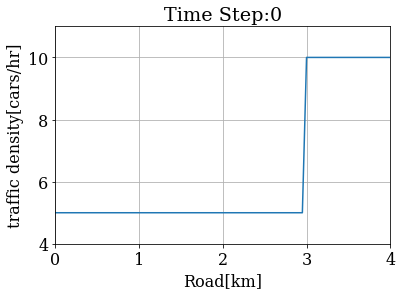

In [6]:
plot(0,x,[rho0])

In [7]:
def traffic_speed(rho,u_max,rho_max):
    return u_max*(1-rho/rho_max)
def traffic_flux(rho,u_max,rho_max):
    return rho*traffic_speed(rho,u_max,rho_max)

In [8]:
def interactive_plot(x,rho_hist):
    nt = len(rho_hist) - 1
    nt_slider = ipywidgets.IntSlider(value=0, min=0, max=nt, step=1,
                                    description='Time Step')
    w = ipywidgets.interactive(plot,n=nt_slider,x=ipywidgets.fixed(x),
                              rho_hist = ipywidgets.fixed(rho_hist))
    return w

In [9]:
interactive_plot(x,[rho0])

interactive(children=(IntSlider(value=0, description='Time Step', max=0), Output()), _dom_classes=('widget-int…

def lax_fredrichs(rho0,nt,dt,dx,u_max,rho_max):
    
    rho_hist = rho0.copy()
    for n in range (nt):
        rho = rho0.copy()
        for i in range (1,nx-1):
            rho0[i] = 0.5*(rho[i+1]+rho[i-1]) - (2dt/dx)*[traffic_flux(rho[i+1],u_max,rho_max) 
                                               -traffic_flux(rho[i-1],u_max,rho_max)]
        rho_hist.append(rho0)
    return rho_hist
    

In [10]:
def lax_fredrichs(rho0,nt,dt,dx,u_max,rho_max):
    rho_hist = [rho0.copy()] # to convert into list of rho0
    rho = rho0.copy()
    nx = len(rho0)
    nx = rho0.size
    for n in range (nt):
        rhon = rho.copy()
        F = traffic_flux(rhon,u_max,rho_max)
        for i in range (1, nx-1):
            rho[i] = 0.5*(rhon[i+1]+rhon[i-1]) - (dt/(2*dx))*(F[i+1]-F[i-1])
        
        rho_hist.append(rho.copy())
    return rho_hist

In [11]:
nt = 80

sigma = 0.5

dt = sigma * dx / u_max



rho_hist = lax_fredrichs(rho0, nt, dt, dx, u_max, rho_max)

interactive_plot(x,rho_hist)

interactive(children=(IntSlider(value=0, description='Time Step', max=80), Output()), _dom_classes=('widget-in…

In [13]:
nt = 40
sigma = 0.5
dt = sigma * dx / u_max

rho_hist = lax_fredrichs(rho0, nt, dt, dx, u_max, rho_max)
interactive_plot(x,rho_hist)


interactive(children=(IntSlider(value=0, description='Time Step', max=40), Output()), _dom_classes=('widget-in…

In [14]:
def traffic_jacobian(rho,u_max,rho_max):
    J = u_max*(1-2*rho/rho_max)
    return J

def lax_wendroff(rho0, nt, dt, dx, u_max, rho_max):
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    nx = len(rho0)
    nx = rho0.size
    for n in range(nt):
        rhon = rho.copy()
        F = traffic_flux(rhon,u_max,rho_max)
        J = traffic_jacobian(rhon,u_max,rho_max)
        for i in range(1,nx-1):
            rho[i] = rhon[i] - (dt/(2*dx)) * (F[i+1]-F[i-1]) + (dt**2/(4*dx**2))*((J[i]+J[i+1])*(F[i+1]-F[i])
                                                                                  -(J[i-1]+J[i])*(F[i]-F[i-1]))
                                                                
        rho_hist.append(rho.copy())                                                                     
    
    return rho_hist
    

In [15]:
nt = 40
sigma = 0.5
dt = sigma * dx / u_max

rho_hist = lax_wendroff(rho0, nt, dt, dx, u_max, rho_max)
interactive_plot(x,rho_hist)


interactive(children=(IntSlider(value=0, description='Time Step', max=40), Output()), _dom_classes=('widget-in…

In [16]:
nt = 80
sigma = 0.5
dt = sigma * dx / u_max

rho_hist = lax_wendroff(rho0, nt, dt, dx, u_max, rho_max)
interactive_plot(x,rho_hist)

interactive(children=(IntSlider(value=0, description='Time Step', max=80), Output()), _dom_classes=('widget-in…

In [19]:
def maccormack(rho0, nt, dt, dx, bc_values, *args):
    
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    rho_star = rho.copy()
    for n in range(nt):
        
        F = traffic_flux(rho, *args)
        
        rho_star[1:-1] = (rho[1:-1] -
                          dt / dx * (F[2:] - F[1:-1]))
        
        F = traffic_flux(rho_star, *args)
        
        rho[1:-1] = 0.5 * (rho[1:-1] + rho_star[1:-1] -
                           dt / dx * (F[1:-1] - F[:-2]))
        
        rho[0] = bc_values[0]
        
        rho[-1] = bc_values[1]
        
        rho_hist.append(rho.copy())
    return rho_hist

In [22]:
sigma = 1.0
dt = sigma * dx / u_max  


rho_hist = maccormack(rho0, nt, dt, dx, (rho0[0], rho0[-1]),u_max, rho_max)
interactive_plot(x,rho_hist)

interactive(children=(IntSlider(value=0, description='Time Step', max=80), Output()), _dom_classes=('widget-in…